<span style="color:green;font-weight:bold">Name : Rashmi Bhaskar 

<span style="color:green;font-weight:bold">Github Username : rashmibhaskar

<span style="color:green;font-weight:bold">USC ID : 4408460333

In [16]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from IPython.display import display

## 1.Transfer Learning for Image Classification

#### It is highly recommended that you complete this project using Keras and Python.

#### (a)In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.

### (b) Data Exploration and Pre-processing

#### i.Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.

#### ii.Randomly select [0.7ni] images from each folder as your training set, [0.15ni] as validation set, and the rest as your test set, where ni is the number of images in folder i and d x e is the ceiling of x.

#### iii.In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV. - resizing to (224,224) is done as part of data augmentation and dataset generation from directory

In [25]:
#Reading labels from csv file
class_df = pd.read_excel('../data/Data/Classes.xlsx', names=["labels","class"])
labels = class_df["labels"].to_list()

In [26]:
# Creating Train / Val / Test folders 
directory = "../data/Data/" #data root path

#Delete if already exists
if os.path.exists(directory +'train/'):
    shutil. rmtree(directory +'train/')
if os.path.exists(directory +'test/'):
    shutil. rmtree(directory +'test/')
if os.path.exists(directory +'val/'):
    shutil. rmtree(directory +'val/')
    
#create empty folders
for label in labels:
    if not os.path.exists(directory +'train/' + label):
        os.makedirs(directory +'train/' + label)
    if not os.path.exists(directory +'val/' + label):
        os.makedirs(directory +'val/' + label)
    if not os.path.exists(directory +'test/' + label):
        os.makedirs(directory +'test/' + label)

# Creating partitions of the data after shuffling
    src = directory +'images/'+ label 

    all_files = os.listdir(src)
    np.random.shuffle(all_files)
    train, val, test = np.split(np.array(all_files), [int(.7*len(np.array(all_files))), int(.85*len(np.array(all_files)))])

    train = [src+'/'+ name for name in train.tolist()]
    val = [src+'/' + name for name in val.tolist()]
    test = [src+'/' + name for name in test.tolist()]

    print('Total images in ',directory +'images/'+ label,': ', len(all_files))
    print('Training: ', len(train))
    print('Validation: ', len(val))
    print('Testing: ', len(test))
    print("----------------------------------------------------------------------")

    # Copying images
    for name in train:
        shutil.copy(name, directory +'train/' + label)

    for name in val:
        shutil.copy(name, directory +'val/' + label)

    for name in test:
        shutil.copy(name, directory +'test/' + label)

Total images in  ../data/Data/images/005.Crested_Auklet :  44
Training:  30
Validation:  7
Testing:  7
----------------------------------------------------------------------
Total images in  ../data/Data/images/013.Bobolink :  60
Training:  42
Validation:  9
Testing:  9
----------------------------------------------------------------------
Total images in  ../data/Data/images/015.Lazuli_Bunting :  58
Training:  40
Validation:  9
Testing:  9
----------------------------------------------------------------------
Total images in  ../data/Data/images/023.Brandt_Cormorant :  59
Training:  41
Validation:  9
Testing:  9
----------------------------------------------------------------------
Total images in  ../data/Data/images/040.Olive_sided_Flycatcher :  60
Training:  42
Validation:  9
Testing:  9
----------------------------------------------------------------------
Total images in  ../data/Data/images/041.Scissor_tailed_Flycatcher :  60
Training:  42
Validation:  9
Testing:  9
------------

### (c) Transfer Learning

#### i.When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

#### ii.To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV


#### Here, I am using ImageDataGenerator along with flow_from_directory() - The combination of these two functionalities does the following tasks and enable to be done on the fly while the model is being trained.

#### 1 - data augmentation(rotation,crop,zoom,contrasting and flipping)
#### 2 - reads each image from the folder, changes its size to 224X224,creates a dataset along with converting its corresponding label to one hot encoded labels(since we are dealing with multi-class labels in our classification problem)

#### I preferred the following image augmentation features: Rotation,Translation,Zoom,Brightness and horizontal Flip for training both VGG16 and EffecientNetB0. The combination of these feature values gave me the best result of the models respectively.

In [27]:
train_datagen = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    brightness_range=(1.0,1.0),
                                    horizontal_flip=True)


valid_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_dir = os.path.join(directory, 'train')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    )

valid_dir = os.path.join(directory, 'val')
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    )

test_dir = os.path.join(directory, 'test')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    shuffle = False
                                                    )

Found 820 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 178 images belonging to 20 classes.


#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

#### iv.Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

#### v.Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.

<span style="color:green;font-weight:bold">VGG16 MODEL

#### Here, I am using epochs as 50 as it yielded the best model when compared to 100 epochs.
#### For the VGG model, I did not prefer the process_input features for data augmentation, since it seemed to overfit the model with training accuracy of 97% and test accuracy of 56%

In [29]:
vgg_model = VGG16(include_top=False, weights = "imagenet", input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = BatchNormalization()(flat1)
class1 = Dense(2048, activation='relu')(class1)
class1 = Dropout(0.2)(class1)
output = Dense(20, activation='softmax')(class1)

model_vgg = Model(inputs = vgg_model.input, outputs = output)
model_vgg.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# adding metrics along with compile
model_vgg.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',metrics.Precision(), metrics.Recall()])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10,mode='min')

history_vgg = model_vgg.fit(train_generator,
                    validation_data = valid_generator,
                    epochs=50, batch_size=5,callbacks=[early_stop], verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### Here, we are asked to plot graph for training and validation errors

#### ( https://piazza.com/class/l7149q4oxue34e/post/1952 ) post says: "'Loss' is the objective function that we seek to minimize during training. It's not the same thing as 'error'".So, I used 1-accuracy to get the error.

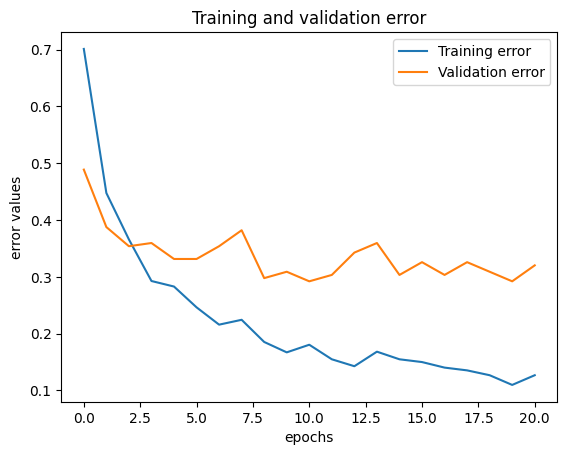

<Figure size 640x480 with 0 Axes>

In [7]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
error = [1-i for i in acc]
val_error = [1-i for i in val_acc]

epochs = range(len(acc))

plt.plot(epochs, error, label='Training error')
plt.plot(epochs, val_error, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('epochs')
plt.ylabel('error values')
plt.legend(loc=0)
plt.figure()

plt.show()

In [30]:
# model_vgg.load_weights("VGG.h5") 
print("-------------------------")
print("VGG METRICS")
print("-------------------------")

predictions_vgg = model_vgg.predict(test_generator)
predicted_labels_vgg = np.argmax(predictions_vgg ,axis=1)
true_labels_vgg = test_generator.classes
print(classification_report(true_labels_vgg, predicted_labels_vgg,target_names=labels))

# train_score = model_vgg.evaluate(train_generator)
# #adding f1_score
# train_score.append(2 * (train_score[2] * train_score[1]) / (train_score[2] + train_score[1]))

scores_vgg = model_vgg.evaluate(test_generator)
#adding f1_score
scores_vgg.append(2 * (scores_vgg[2] * scores_vgg[1]) / (scores_vgg[2] + scores_vgg[1]))

display(pd.DataFrame({"VGG Test":scores_vgg},index=["Loss","Accuracy","Precision","Recall","F1_Score"]))


-------------------------
VGG METRICS
-------------------------
6/6 [==============================] - 37s 6s/step
                               precision    recall  f1-score   support

           005.Crested_Auklet       0.75      0.86      0.80         7
                 013.Bobolink       0.88      0.78      0.82         9
           015.Lazuli_Bunting       1.00      0.78      0.88         9
         023.Brandt_Cormorant       0.83      0.56      0.67         9
   040.Olive_sided_Flycatcher       0.57      0.44      0.50         9
041.Scissor_tailed_Flycatcher       0.78      0.78      0.78         9
         067.Anna_Hummingbird       0.75      1.00      0.86         9
          072.Pomarine_Jaeger       0.80      0.89      0.84         9
          076.Dark_eyed_Junco       0.75      0.67      0.71         9
          081.Pied_Kingfisher       1.00      0.89      0.94         9
        082.Ringed_Kingfisher       0.64      0.78      0.70         9
             086.Pacific_Loon   

,VGG Test
Loss,6.504440
Accuracy,0.741573
Precision,0.745763
Recall,0.741573
F1_Score,0.743662


#### The dataframe above represents the Test accuracies for the VGG16 Model. I got these values by evaluating the model against and test dataset.

#### You can find the approximate Train accuracy for VGG16 model in the latest epoch of its training step. ~88.54%

<span style="color:green;font-weight:bold">EFFICEINETB0 MODEL

#### For training EffecientNetB0, I preferred 100 epoch, as it yielded me the best results when compared to 50 epochs.

In [31]:
eff_model = tf.keras.applications.EfficientNetB0(include_top=False, weights = "imagenet", input_shape=(224, 224, 3))

for layer in eff_model.layers:
    layer.trainable=False

flat1_eff = Flatten()(eff_model.layers[-1].output)
class1_eff= BatchNormalization()(flat1_eff)
class1_eff= Dense(2048, activation='relu')(class1_eff)
class1_eff= Dropout(0.2)(class1_eff)
output = Dense(20, activation='softmax')(class1_eff)

model_eff = Model(inputs = eff_model.input, outputs = output)
model_eff.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_eff.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',metrics.Precision(), metrics.Recall()])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10,mode='min')

history_eff = model_eff.fit(train_generator,
                    validation_data = valid_generator,
                    epochs=100, batch_size=5,callbacks=[early_stop], verbose=1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

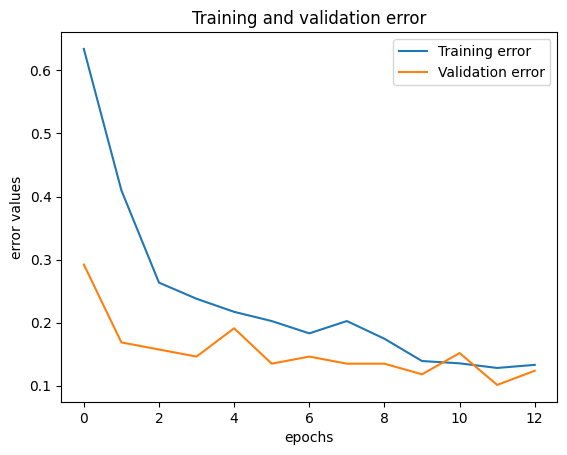

<Figure size 640x480 with 0 Axes>

In [32]:
acc_eff = history_eff.history['accuracy']
val_acc_eff = history_eff.history['val_accuracy']
loss_eff = history_eff.history['loss']
val_loss_eff = history_eff.history['val_loss']
error_eff = [1-i for i in acc_eff]
val_error_eff = [1-i for i in val_acc_eff]

epochs_eff = range(len(acc_eff))

plt.plot(epochs_eff, error_eff, label='Training error')
plt.plot(epochs_eff, val_error_eff, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('epochs')
plt.ylabel('error values')
plt.legend(loc=0)
plt.figure()

plt.show()

In [33]:
print("----------------------")
print("EFFECIENTB0 METRICS")
print("----------------------")

predictions_eff = model_eff.predict(test_generator)
predicted_labels_eff = np.argmax(predictions_eff ,axis=1)
true_labels_eff = test_generator.classes
print(classification_report(true_labels_eff, predicted_labels_eff,target_names=labels))

scores_eff = model_eff.evaluate(test_generator)
#adding f1_score
scores_eff.append(2 * (scores_eff[2] * scores_eff[1]) / (scores_eff[2] + scores_eff[1]))

display(pd.DataFrame({"EffecientB0 Test":scores_eff},index=["Loss","Accuracy","Precision","Recall","F1_Score"]))

----------------------
EFFECIENTB0 METRICS
----------------------
6/6 [==============================] - 5s 609ms/step
                               precision    recall  f1-score   support

           005.Crested_Auklet       0.83      0.71      0.77         7
                 013.Bobolink       1.00      0.89      0.94         9
           015.Lazuli_Bunting       0.90      1.00      0.95         9
         023.Brandt_Cormorant       0.86      0.67      0.75         9
   040.Olive_sided_Flycatcher       0.78      0.78      0.78         9
041.Scissor_tailed_Flycatcher       0.53      0.89      0.67         9
         067.Anna_Hummingbird       1.00      1.00      1.00         9
          072.Pomarine_Jaeger       0.90      1.00      0.95         9
          076.Dark_eyed_Junco       1.00      1.00      1.00         9
          081.Pied_Kingfisher       0.90      1.00      0.95         9
        082.Ringed_Kingfisher       0.90      1.00      0.95         9
             086.Pacific_Loo

,EffecientB0 Test
Loss,12.095322
Accuracy,0.859551
Precision,0.864407
Recall,0.859551
F1_Score,0.861972


#### The dataframe above represents the Test accuracies for the EffecientNetB0 Model. I got these values by evaluating the model against test dataset.

#### You can find the approximate Train accuracy for EffecientNetB0 model in the latest epoch of its training step. ~86.71%

In [34]:
#Deleting the train/test/val folders after both the models have been trained.
if os.path.exists(directory +'train/'):
    shutil. rmtree(directory +'train/')
if os.path.exists(directory +'test/'):
    shutil. rmtree(directory +'test/')
if os.path.exists(directory +'val/'):
    shutil. rmtree(directory +'val/')

#### REFERENCES

[1] - https://pyimagesearch.com/2016/08/10/imagenet-classification-with-python-and-keras/

[2] - https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

[3] - https://www.kaggle.com/questions-and-answers/102677

[4] - https://medium.com/@draj0718/image-classification-and-prediction-using-transfer-learning-3cf2c736589d

[5] - https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060

[6] - https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673

[7] - https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

[8] - https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

[9] - https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

[10] - https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

[11] - https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

[12] - https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

[13] - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

[14] - https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras

[15] - https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
